In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from pathlib import Path

***Notebooks are written for Jupyter and might not display well in Github***


# Loading and processing measured data with MeasuredDats

The goal of this tutorial is to provide a comprehensive workflow for treating measured data using  **CorrAI** <code>MeasuredDats</code>.

## Use case

Measurements were collected from a real-scale benchmark conducted by Nobatek's BEF (Banc d'Essais Façade), which provides experimental cells for testing building façade solutions. Heat exchanges in a cell are limited to five of its faces, while the sixth face is dedicated to the tested solution. Internal temperature and hydrometry conditions can be controlled or monitored, and external conditions, such as temperatures and solar radiation, are measured.

The experimental setup is presented in the following figures:

| Figure 1: picture of the benchmark | Figure 2: wall layers from the inside (right) to the outside (left) |
| :---: | :---: |
|<img src="images/etics_pict.png"  height="300"> | <img src="images/etics_sch.png"  height="300"> |

Additional details about the data:
- The measurement campaign spanned from 07/06/2017 to 20/06/2017.
- The acquisition timestep is probably 1 minute.


# Measured data analysis and correction

Measured data are loaded using <code>pandas</code> python library

In [4]:
import pandas as pd

In [5]:
raw_data = pd.read_csv(
    Path(r"resources/tuto_data.csv"),
    sep=",",
    index_col=0,
    parse_dates=True
)

Plotting the raw temperatures gives precious information on the dataset

<Axes: >

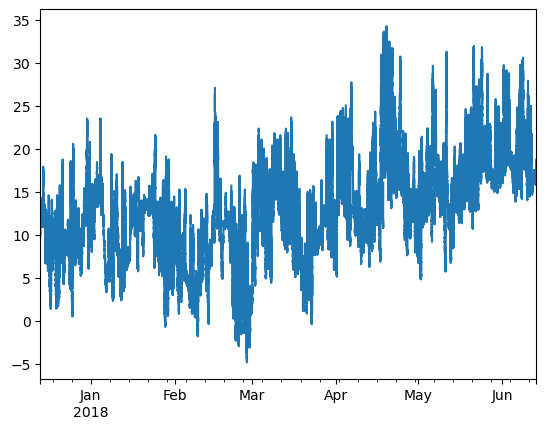

In [6]:
raw_data['T_ext'].plot()

At first sight, a dataset may look fine, but missing values or incorrect variations are not always visible on a graph. The following steps are proposed to ensure data quality.

#### 1- Identify anomalies:
- __upper__ and __lower__ values as boundaries. Measured values outside the interval are considered wrong
- upper and lower "__rates__". Measured value increasing beyond or below a defined threshold are considered wrong

These boundaries are set depending on the measured physical phenomenon.
For example, the boundaries for power and temperature will be configured differently.

#### 2- Missing data interpolation
Physical models do not tolerate missing values well. Therefore, for each sensor, we provide a method to interpolate missing data. We use a linear interpolation method to fill in the gaps between missing points. Errors at the beginning or end of the time series are filled with the first or last correct value.

#### 3- Reducing dataset size
Finally, a 1-minute acquisition timestep provides a heavy dataset.
To make the dataset more manageable, we provide an aggregation method to _resample_ the dataset. Resampling allows the data to be aggregated into larger time intervals without losing critical information.

## Using MeasuredDat to perform operations on data

The <code>MeasuredDats</code> **corrai** object is designed to specify transformations to apply to a measured dataset and to visualize their effects.
The measured are classified in _categories_ (eg. temperature, power, control, etc.).
The transformations can be specified at category level, or can be common to all the categories.
At the end of the process a resampler can be specified. It may be used to align data on a regular time index or reduce the size of the dataset.
<code>MeasuredDats</code> uses **Scikit Learn** _pipelines_. The transformers are <code>corrai.custom_transfomers</code> objects, they inherit from scikit base class <code>BaseEstimator</code> and <code>TransformerMixin</code>. These transformer ensure that Pandas <code>DataFrame</code> with <code>DateTimeIndex</code> are used through the process

The figure below describe a "pipeline" that apply a series of correction to the dataset.

<img src="images/pipe.png"  height="400">

4 successive transformations are applied: 2 category transformations, a common transformation and a resampling operation.

The **categories** are specified using <code>data_type_dict</code> :
```
category_dict = {
    "Temperatures": ["temp_1", ["temp_2"],
    "Power": ["pow_1"],
    "radiation": ["Sol_rad"]
    }
```

The **category transformations** are specified :
```
category_transformations = {
    "Temperatures":{
        "ANOMALIES": [
            ["drop_threshold", {"upper": 40000, "lower": 0}],
            ["drop_time_gradient", {"upper_rate": 5000, "lower_rate": 0}],
        ],
        "RESAMPLE": "mean"
    },
    "Power": {
        "ANOMALIES": [
            ["drop_threshold", {"upper": 50, "lower": -2}],
            ["drop_time_gradient", {"upper_rate": 5000, "lower_rate": 0}],
        ],
        "PROCESS": [
            ["apply_expression", {"expression": x / 1000}]
        ],
        "RESAMPLE": "mean"
    },
    "radiation": {}
},
```

- The dictionary keys must match the category defined in <code>category_dict</code>
- For each category you can specify as much transformer as you want. Similar name must be given in each category if you want transformer to be used in the same _"category transformation"_ (eg. ANOMALIES)
- For each transformer a list of transformation is given. They are defined by a list with two elements [custom_transformer key, {custom transformer args}]
- An optional key "RESAMPLE" may be given to specify the category aggregation method in case of resampling. By default, resampling method is mean
- If the category doesn't require any transformation, specify an empty directory

The **common transformations** are specified :

```
common_transformations={
    "COMMON": [
        ["interpolate", {"method": 'linear'}],
        ["fill_na", {"method": 'bfill'}],
        ["fill_na", {"method": 'bfill'}]
    ]
}
```
- The dictionary keys are the manes of the common transformers
- For each transformer a list of transformation is given. They are defined by a list of two elements [custom_transformer key, {custom transformer args}]

The **transformer list** :
Lastly you can specify the order of the transformations using <code>transformers_list</code>. For example <code>transformers_list = ["ANOMALIES", "COMMON", "PRECESS"]</code>.
- If <code>transformer_list</code> is left to <code>None</code>, transformers list hold all the category_transformers, than all the common transformers
- This list can be changed at all time.
- You don't have to use all the transformers,
- Resampling will always be put at the end of the pipeline


Here is an example for the dataset we just loaded

In [7]:
from corrai.measure import MeasuredDats
from corrai.measure import get_transformers_keys

The function <code>get_transformers_keys()</code> id designed to expose the available transformers names and help you configure <code>MeasuredDats</code>

In [8]:
get_transformers_keys()

dict_keys(['dropna', 'rename_columns', 'sk_transformer', 'drop_threshold', 'drop_time_gradient', 'apply_expression', 'time_gradient', 'fill_na', 'resample', 'interpolate', 'gaussian_filter'])

In [40]:
my_data = MeasuredDats(
    data = raw_data,
    category_dict = {
        "temperatures": [
            'T_Wall_Ins_1', 'T_Wall_Ins_2', 'T_Ins_Ins_1', 'T_Ins_Ins_2',
            'T_Ins_Coat_1', 'T_Ins_Coat_2', 'T_int_1', 'T_int_2', 'T_ext', 'T_garde'
        ],
        "illuminance": ["Lux_CW"],
        "radiation": ["Sol_rad"]
    },
    category_transformations = {
        "temperatures": {
            "ANOMALIES": [
                ["drop_threshold", {"upper": 100, "lower": -20}],
                ["drop_time_gradient", {"upper_rate": 2, "lower_rate": 0}]
            ],
            "RESAMPLE": 'mean',
        },
        "illuminance": {
            "ANOMALIES": [
                ["drop_threshold", {"upper": 1000, "lower": 0}],
            ],
            "RESAMPLE": 'mean',
        },
        "radiation": {
            "ANOMALIES": [
                ["drop_threshold", {"upper": 1000, "lower": 0}],
            ],
            "RESAMPLE": 'mean',
        }
    },
    common_transformations={
		"COMMON": [
            ["interpolate", {"method": 'linear'}],
		    ["fill_na", {"method": 'bfill'}],
		    ["fill_na", {"method": 'bfill'}]
        ]
    },
    transformers_list=["ANOMALIES", "COMMON"]
)

Note that <code>transformers_list</code> could have been left to None are we are applying the only category transformer, than the common transformer.

In [41]:
my_data.get_pipeline()

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ANOMALIES_temperatures',
                                                  Pipeline(steps=[('pddropthreshold',
                                                                   PdDropThreshold(lower=-20,
                                                                                   upper=100)),
                                                                  ('pddroptimegradient',
                                                                   PdDropTimeGradient(lower_rate=0,
                                                                                      upper_rate=2))]),
                                                  ['T_Wall_Ins_1',
                                                   'T_Wall_Ins_2',
                                                   'T_Ins_Ins_1', 'T_Ins_Ins_2',
                                                   'T_Ins_Coat_1',
                                                   'T_Ins_Coat_2...
                                                                   PdDropThreshold(lower=0,
                                                                                   upper=1000))]),
                                                  ['Lux_CW']),
                                                 ('ANOMALIES_radiation',
                                                  Pipeline(steps=[('pddropthreshold',
                                                                   PdDropThreshold(lower=0,
                                                                                   upper=1000))]),
                                                  ['Sol_rad'])],
                                   verbose_feature_names_out=False)),
                ('pipeline',
                 Pipeline(steps=[('pdinterpolate',
                                  PdInterpolate(method='linear')),
                                 ('pdfillna-1', PdFillNa(method='bfill')),
                                 ('pdfillna-2', PdFillNa(method='bfill'))]))])

The <code>plot</code> method can be used to plot the data.

Provide a <code>list</code> to the argument <code>cols</code> to specify the entry you want to plot.

A new y axis will be created for each data type.

In [49]:
my_data.plot(
    cols=['T_Wall_Ins_1', 'Sol_rad', 'Lux_CW'],
    begin='2018-04-15',
    end='2018-04-18',
    title='Plot uncorrected data',
    marker_raw=True,
    line_raw=False,
    plot_raw = True,
)

Plotted data are the <code>corrected_data</code> obtained after going through the pipeline described in the <code>MeasuredDats</code> object's <code>transformers_list</code>. You can specify an alternative transformers_list using the <code>plot</code> function argument <code>transformers_list</code>.

Use <code>plot_raw=True</code> to display raw data. This is useful to assess the impact of the correction and of the resampling methods


The <code>get_missing_values_stats</code> method gives information on the amount of missing values.
You can get it for raw, corrected or partially corrected data depending on the transformers specified in <code>transformers_list</code>

Let's have a look for raw data. We specify an empty <code>transformers_list</code> that create a pipeline with a single Identity transformer

In [74]:
my_data.get_missing_value_stats(transformers_list=[])

{'Number_of_missing': T_Wall_Ins_1    257321
 T_Wall_Ins_2    257321
 T_Ins_Ins_1     257321
 T_Ins_Ins_2     257321
 T_Ins_Coat_1    257321
 T_Ins_Coat_2    257321
 T_int_1         257321
 T_int_2         257321
 Lux_CW          257321
 T_ext           253914
 T_garde         253914
 Sol_rad         253914
 dtype: int64,
 'Percent_of_missing': T_Wall_Ins_1    1.907183
 T_Wall_Ins_2    1.907183
 T_Ins_Ins_1     1.907183
 T_Ins_Ins_2     1.907183
 T_Ins_Coat_1    1.907183
 T_Ins_Coat_2    1.907183
 T_int_1         1.907183
 T_int_2         1.907183
 Lux_CW          1.907183
 T_ext           3.205959
 T_garde         3.205959
 Sol_rad         3.205959
 dtype: float64}

Before correction, the journal shows that ~2% of the data are missing for the temperature sensor and ~3% for external temperature, "garde" temperature and solar radiation. it corresponds to data having a timestamp, but with missing value. In this specific case, this is not related to sensors errors. 2 distinct acquisition device were used to perform the measurement. The merging of the data from the two devices created troubles in timestamp "alignment". Also measurement stopped a bit earlier for the second device.

#### 1- Identify anomalies:
Now let's apply the ANOMALIES transformer to delete invalid data according to the specifications

In [75]:
my_data.get_missing_value_stats(["ANOMALIES"])

{'Number_of_missing': T_Wall_Ins_1    257320
 T_Wall_Ins_2    257319
 T_Ins_Ins_1     257316
 T_Ins_Ins_2     257318
 T_Ins_Coat_1    257321
 T_Ins_Coat_2    257321
 T_int_1         250413
 T_int_2         251806
 T_ext           253770
 T_garde         247266
 Lux_CW          256321
 Sol_rad         253914
 dtype: int64,
 'Percent_of_missing': T_Wall_Ins_1    1.907565
 T_Wall_Ins_2    1.907946
 T_Ins_Ins_1     1.909090
 T_Ins_Ins_2     1.908327
 T_Ins_Coat_1    1.907183
 T_Ins_Coat_2    1.907183
 T_int_1         4.540568
 T_int_2         4.009545
 T_ext           3.260853
 T_garde         5.740230
 Lux_CW          2.288391
 Sol_rad         3.205959
 dtype: float64}

It looks like the applied corrections removed several data.
For example, the sensors measuring the cell internal temperature have now up to __4.7%__ of missing data.

Few corrections were applied to the outside temperature sensor.

The journal of correction holds further information on the gaps of data.
For example if we want to know more about the missing values of <code>T_int_1</code>

In [76]:
my_data.get_gaps_description(cols=["T_int_1"], transformers_list=["ANOMALIES"])

,T_int_1,combination
count,11220,28007
mean,0 days 00:02:03.695187165,0 days 00:02:08.995608240
std,0 days 00:00:37.268341462,0 days 00:00:33.216726828
min,0 days 00:02:00,0 days 00:02:00
25%,0 days 00:02:00,0 days 00:02:00
50%,0 days 00:02:00,0 days 00:02:00
75%,0 days 00:02:00,0 days 00:02:00
max,0 days 01:02:00,0 days 01:02:00


- There are 11220 gaps.
- The size of 75% of these gaps do not exceed 1 timestep (~1min)
- The biggest is 1h

It is also possible to "aggregate" the gaps in to know when at least one of the data is missing

In [78]:
my_data.get_gaps_description(transformers_list=["ANOMALIES"])["combination"]

count                        28007
mean     0 days 00:02:08.995608240
std      0 days 00:00:33.216726828
min                0 days 00:02:00
25%                0 days 00:02:00
50%                0 days 00:02:00
75%                0 days 00:02:00
max                0 days 01:02:00
Name: combination, dtype: object

- There are 28007 gaps (~10% of the dataset).
- The size of 75% of these gaps do not exceed 1 timestep (~1min)
- The biggest gap is 1h

There is not a lot of difference. It looks like the values are missing at the same timestamps.

This is a good news, it means that there are a lot of periods with all data available

The plotting method <code>plot_gaps</code> can be used to visualize where the gap happened.

This dataset holds a lot of values, sol we just plot the entry <code>'T_int_1'</code> that is supposed to have the more gaps

We are interested in gaps lasting more than 15 minutes.

In [79]:
import datetime as dt
my_data.plot_gaps(
    cols=['T_Wall_Ins_1', 'Sol_rad', 'Lux_CW'],
    begin='2018-03-25',
    end='2018-03-25',
    gaps_timestep=dt.timedelta(minutes=15),
    transformers_list=["ANOMALIES"]
)

There seem to be only 1 gap greater than 15 minutes, it happens the 2018-03-25 between ~02:00 and ~3:00.
This is the gap we identified in the correction journal.

#### 2- Missing data interpolation
In our example, the same method is used to fill the gaps for all categories.
It is described in <code>common_transformations</code>
Below is the object transformers list:

In [81]:
my_data.transformers_list

['ANOMALIES', 'COMMON']

To get the corrected data we just need to call <code>get_corrected_data</code> method, with default arguments

In [83]:
my_data.get_corrected_data()

,T_Wall_Ins_1,T_Wall_Ins_2,T_Ins_Ins_1,T_Ins_Ins_2,T_Ins_Coat_1,T_Ins_Coat_2,T_int_1,T_int_2,T_ext,T_garde,Lux_CW,Sol_rad
2017-12-13 09:40:00,12.808084,12.788604,11.142730,10.356493,9.037704,8.815204,13.237799,13.705660,9.528805,12.753293,119.843498,2.889285
2017-12-13 09:41:00,12.795591,12.794301,11.148800,10.366114,9.049955,8.831131,13.237171,13.705033,9.528805,12.753293,135.268952,2.889285
2017-12-13 09:42:00,12.783099,12.799997,11.154871,10.375734,9.062207,8.847058,13.236543,13.704405,9.551196,12.753554,150.694406,2.706999
2017-12-13 09:43:00,12.807767,12.791339,11.163375,10.383073,9.089917,8.871467,13.236857,13.704719,9.579727,12.753606,140.410770,2.706999
2017-12-13 09:44:00,12.802952,12.792391,11.154068,10.390266,9.092634,8.873949,13.236700,13.705033,9.580250,12.753345,150.694406,3.436142
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-13 13:39:00,21.132237,21.105958,19.989807,19.382145,18.075350,17.876228,21.597250,21.610499,18.198367,21.128949,119.843498,95.308122
2018-06-13 13:40:00,21.130947,21.109509,19.979964,19.383395,18.154094,17.941545,21.597093,21.609397,18.354154,21.128267,202.112586,108.432690
2018-06-13 13:41:00,21.120511,21.097459,19.973662,19.368755,18.276968,18.086286,21.595834,21.608610,18.540867,21.128162,119.843498,121.192687
2018-06-13 13:42:00,21.131472,21.107498,19.976100,19.368419,18.394899,18.211688,21.595677,21.608453,18.690322,21.128110,263.814402,124.109258


We can check the effect of the transformation

In [84]:
my_data.get_missing_value_stats()

{'Number_of_missing': T_Wall_Ins_1    262324
 T_Wall_Ins_2    262324
 T_Ins_Ins_1     262324
 T_Ins_Ins_2     262324
 T_Ins_Coat_1    262324
 T_Ins_Coat_2    262324
 T_int_1         262324
 T_int_2         262324
 T_ext           262324
 T_garde         262324
 Lux_CW          262324
 Sol_rad         262324
 dtype: int64,
 'Percent_of_missing': T_Wall_Ins_1    0.0
 T_Wall_Ins_2    0.0
 T_Ins_Ins_1     0.0
 T_Ins_Ins_2     0.0
 T_Ins_Coat_1    0.0
 T_Ins_Coat_2    0.0
 T_int_1         0.0
 T_int_2         0.0
 T_ext           0.0
 T_garde         0.0
 Lux_CW          0.0
 Sol_rad         0.0
 dtype: float64}

Wow, perfect dataset !

Be careful 0 data missing doesn't mean 0 problem.
 If you had a crappy dataset, it is still crappy.
 You just filled the gaps by copying values or drawing lines between (_what seems to be_) valid points

#### 3- Reducing dataset size
As we said earlier 1min timestep is too small.
Regarding the physical phenomenon involved here, we could say that 5min is ok.
Let's have a look at our corrected data versus the raw data.
We select a period around the gap we identified (from the 2018-03-24 to the 2018-03-26)

In [86]:
my_data.plot(
    title="Raw data versus corrected data",
    cols=['T_int_1'],
    begin='2018-03-25 00:00:00',
    end='2018-03-25 05:00:00',
    plot_raw=True,
    plot_corrected=True,
    line_raw=False,
    marker_corrected=True,
    resampling_rule='5T'
)

On the above graph you can see the effects of mean resampling, that diminishes the number of points and smooths out the data.

The gap have been filled using linear interpolation at the required timestep.

It is important to compare your data before and after applying the correction methods. For example, resampling with a large timestep can lead to a loss of information